# Imports

In [100]:
from pathlib import Path
import pandas as pd
import torchaudio
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

Dataset & file collection

In [81]:
DATASET_ROOT = Path("data")
AUDIO_EXTS = {".wav", ".mp3", ".flac",".ogg", ".m4a", ".aac"}

paths = [p for p in DATASET_ROOT.rglob("*") if p.suffix.lower() in AUDIO_EXTS]
df = pd.DataFrame({"path": paths}).drop_duplicates(subset=["path"]).reset_index(drop=True)

df["path"] = df["path"].apply(lambda p: Path(p))
df = df[df["path"].apply(lambda p: p.exists())].reset_index(drop=True)

In [82]:
def probe(path: Path):
    try:
        info = torchaudio.info(str(path))
        sr = int(info.sampole_rate); n_frames = int(info.num_frames); ch = int(info.num_channels)
        dur = (n_frames / sr) if sr > 0 else 0.0
        return dur, sr, ch, False
    except Exception:
        pass

    try: # wav files
        with sf.SoundFile(str(path)) as f:
            sr = int(f.samplerate); ch = int(f.channels); n_frames = int(len(f))
            dur = (n_frames / sr) if sr > 0 else 0.0
        return dur, sr, ch, False
    except Exception:
        pass


In [84]:
meta = df["path"].map(probe)
df[["duration_s","sample_rate","n_channels","is_corrupted"]] = pd.DataFrame(meta.tolist(), index=df.index)

df = df[df["path"].map(lambda p: p.exists())].reset_index(drop=True)
df_clean = df[(~df["is_corrupted"]) & (df["duration_s"].fillna(0) >= 0.2)].copy()

df_clean["folder"] = df_clean["path"].map(lambda p: p.parent.name)


EMO_MAP = {
    "01":"neutral","02":"calm","03":"happy","04":"sad",
    "05":"angry","06":"fearful","07":"disgust","08":"surprised"
}
def parse_emotion_from_name(p: Path):
    name = p.stem  
    parts = name.split("-")
    if len(parts) >= 3 and parts[2].isdigit() and len(parts[2]) == 2:
        return EMO_MAP.get(parts[2])
    return None

if "label" in df_clean.columns:
    df_clean["emotion"] = df_clean["label"].astype(str)
else:
    df_clean["emotion"] = df_clean["path"].map(parse_emotion_from_name)

In [85]:
df_clean["duration_round_s"] = df_clean["duration_s"].round(1)
duration_counts = (
    df_clean.groupby("duration_round_s", as_index=False)
            .size()
            .rename(columns={"size":"count"})
            .sort_values("duration_round_s")
)


folder_counts = (
    df_clean.groupby("folder", as_index=False)
            .size()
            .rename(columns={"size":"count"})
            .sort_values("count", ascending=False)
)


if df_clean["emotion"].notna().any():
    emotion_counts = (
        df_clean.dropna(subset=["emotion"])
                .groupby("emotion", as_index=False)
                .size()
                .rename(columns={"size":"count"})
                .sort_values("count", ascending=False)
    )
else:
    emotion_counts = pd.DataFrame(columns=["emotion","count"])

In [86]:
print("Usable clips:", len(df_clean))
print("\nDurations (rounded to 0.1s):")
display(duration_counts.head(10))
print("\nFiles per folder:")
display(folder_counts.head(10))
print("\nFiles per emotion:")
display(emotion_counts.head(10))

Usable clips: 1380

Durations (rounded to 0.1s):


,duration_round_s,count
0,2.9,1
1,3.0,4
2,3.1,36
3,3.2,65
4,3.3,84
5,3.4,115
6,3.5,184
7,3.6,192
8,3.7,188
9,3.8,147



Files per folder:


,folder,count
0,Actor_02,60
12,Actor_14,60
21,Actor_23,60
20,Actor_22,60
19,Actor_21,60
18,Actor_20,60
17,Actor_19,60
16,Actor_18,60
15,Actor_17,60
14,Actor_16,60



Files per emotion:


,emotion,count
0,angry,184
1,calm,184
2,disgust,184
3,fearful,184
4,happy,184
6,sad,184
7,surprised,184
5,neutral,92


# Feature Visualization

In [88]:
TARGET_SR = 1600
N_MFCC = 20 # can range from 13 - 40
N_MELS = 64
HOP_MS = 10
WIN_MS = 25

resamplers = {}

def load_mono_resampled(path, target_sr=TARGET_SR):
    wav, sr = torchaudio.load(str(path))
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != target_sr:
        key = (sr, target_sr)
        if key not in resamplers:
            resamplers[key] = torchaudio.transforms.Resample(sr, target_sr)
        wav = resamplers[key](wav)
        sr = target_sr
    return wav.squeeze(0), sr

In [90]:
hop_length = int(TARGET_SR * HOP_MS / 1000)
win_length = int(TARGET_SR * WIN_MS / 1000)
n_fft = 1 << (win_length - 1).bit_length()

mfcc_tx = torchaudio.transforms.MFCC(
    sample_rate=TARGET_SR,
    n_mfcc=N_MFCC,
    melkwargs=dict(
        n_mels=N_MELS,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        center=True,
        power=2.0,            # power mel-spectrogram before DCT
        f_min=0.0,
        f_max=TARGET_SR/2,
    )
)

wav shape: torch.Size([6247]) sr: 1600
mfcc shape: torch.Size([20, 391])


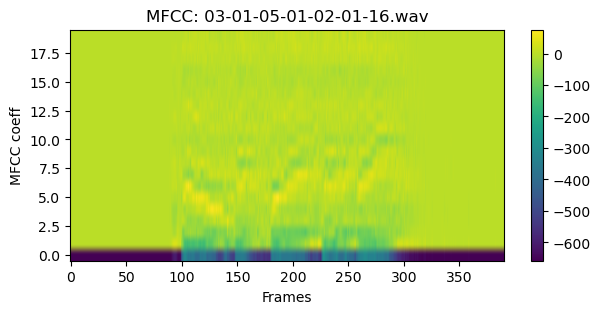

In [91]:
test_path = df_clean.loc[0, "path"]
wav, sr = load_mono_resampled(test_path)
mfcc = mfcc_tx(wav.unsqueeze(0))   # (1, n_mfcc, time)
mfcc = mfcc.squeeze(0)             # (n_mfcc, time)

print("wav shape:", wav.shape, "sr:", sr)
print("mfcc shape:", mfcc.shape)   # expect (N_MFCC, T)

plt.figure(figsize=(7,3))
plt.imshow(mfcc.numpy(), aspect='auto', origin='lower')
plt.colorbar(); plt.title(f"MFCC: {test_path.name}")
plt.xlabel("Frames"); plt.ylabel("MFCC coeff")
plt.show()

In [92]:
N = min(60, len(df_clean))   
subset = df_clean.sample(N, random_state=0).reset_index(drop=True)

rows = []
for i, p in enumerate(subset["path"]):
    try:
        wav, _ = load_mono_resampled(p)
        m = mfcc_tx(wav.unsqueeze(0)).squeeze(0)  # (n_mfcc, T)
        coef_mean = m.mean(dim=1).numpy()         # (n_mfcc,)
        coef_std  = m.std(dim=1).numpy()
        rows.append({
            "path": p,
            **{f"mfcc{i}_mean": coef_mean[i] for i in range(N_MFCC)},
            **{f"mfcc{i}_std":  coef_std[i]  for i in range(N_MFCC)},
        })
    except Exception as e:
        pass

mfcc_df = pd.DataFrame(rows)
print("Processed files:", len(mfcc_df), "out of", N)
mfcc_df.head(3)

Processed files: 60 out of 60


,path,mfcc0_mean,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mfcc10_std,mfcc11_std,mfcc12_std,mfcc13_std,mfcc14_std,mfcc15_std,mfcc16_std,mfcc17_std,mfcc18_std,mfcc19_std
0,data/Actor_05/03-01-08-02-02-01-05.wav,-538.634094,-27.257627,-25.072672,-5.527519,-4.960055,4.578427,3.094726,3.918777,-0.361528,...,7.201501,6.671890,6.040637,6.010224,5.480183,6.527573,5.987572,4.404528,6.519440,3.932338
1,data/Actor_06/03-01-03-01-01-01-06.wav,-580.710327,-50.235477,-32.752506,-6.923063,-1.855390,9.385913,8.365977,4.587392,-8.365840,...,11.546754,9.474778,6.820214,8.375830,6.113042,7.397960,7.995528,5.056407,6.837224,5.482433
2,data/Actor_23/03-01-05-02-02-02-23.wav,-464.792725,-31.839880,-24.368284,-7.021924,7.821591,4.061461,-5.376794,-1.277367,2.407845,...,7.367112,6.427472,4.798452,5.348167,3.862208,5.057909,4.557933,4.103279,4.503560,3.645177


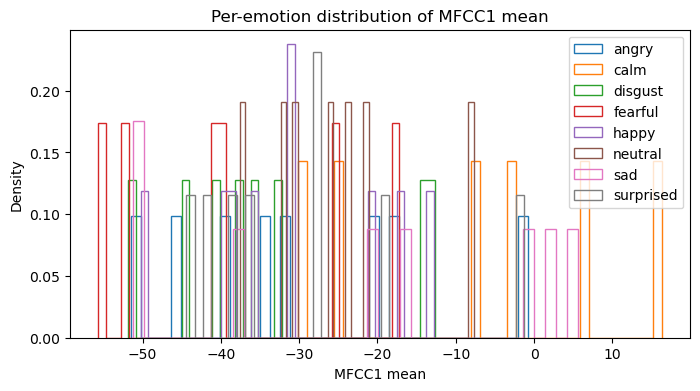

In [95]:
# bring emotion/label along if present
key_cols = ["path"] + [c for c in ["emotion","label"] if c in df_clean.columns]
merge_df = pd.merge(mfcc_df, df_clean[key_cols], on="path", how="left")

# Example: per-emotion distribution of MFCC1 mean
if "emotion" in merge_df.columns:
    plt.figure(figsize=(8,4))
    for emo, group in merge_df.groupby("emotion"):
        vals = group["mfcc1_mean"].dropna().values
        if len(vals) == 0: 
            continue
        plt.hist(vals, bins=40, histtype='step', label=str(emo), density=True)
    plt.title("Per-emotion distribution of MFCC1 mean")
    plt.xlabel("MFCC1 mean"); plt.ylabel("Density"); plt.legend()
    plt.show()


In [96]:

COEF = 1   # 0, 1, or 2

K = 3

if "emotion" in df_clean.columns and df_clean["emotion"].notna().any():
    emos = df_clean["emotion"].dropna().unique().tolist()
    emo_sample = {}
    for e in emos[:3]:  
        emo_sample[e] = df_clean[df_clean["emotion"] == e].sample(min(K, sum(df_clean["emotion"] == e)), random_state=0)["path"].tolist()
else:
    emo_sample = {"all": df_clean.sample(min(3*K, len(df_clean)), random_state=0)["path"].tolist()}

emo_sample

{'angry': [PosixPath('data/Actor_14/03-01-05-01-01-02-14.wav'),
  PosixPath('data/Actor_15/03-01-05-01-01-02-15.wav'),
  PosixPath('data/Actor_16/03-01-05-01-01-01-16.wav')],
 'fearful': [PosixPath('data/Actor_14/03-01-06-01-01-01-14.wav'),
  PosixPath('data/Actor_15/03-01-06-01-01-01-15.wav'),
  PosixPath('data/Actor_16/03-01-06-01-01-02-16.wav')],
 'disgust': [PosixPath('data/Actor_14/03-01-07-01-02-02-14.wav'),
  PosixPath('data/Actor_15/03-01-07-01-02-02-15.wav'),
  PosixPath('data/Actor_16/03-01-07-01-02-01-16.wav')]}

In [97]:
def mfcc_coef_sequence(path, coef_idx=COEF):
    wav, _ = load_mono_resampled(path)
    M = mfcc_tx(wav.unsqueeze(0)).squeeze(0)  # (n_mfcc, T)
    return M[coef_idx].cpu().numpy()          # (T,)

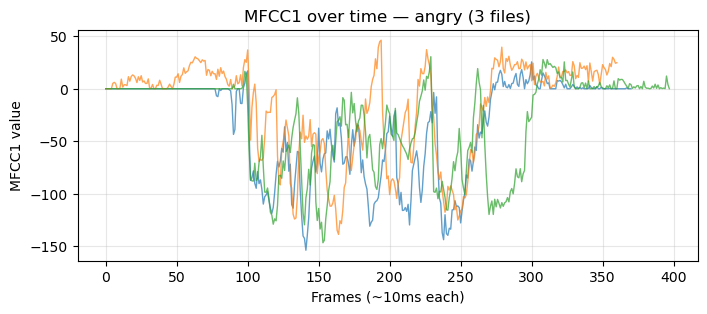

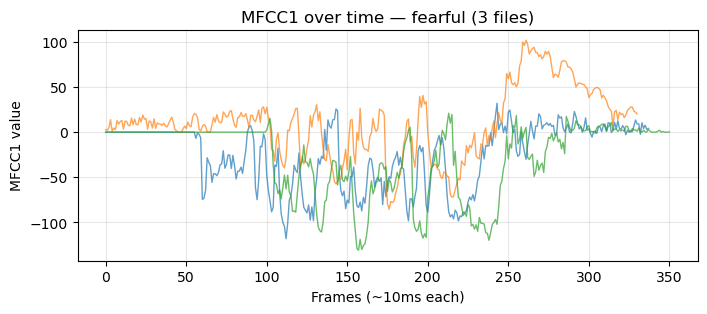

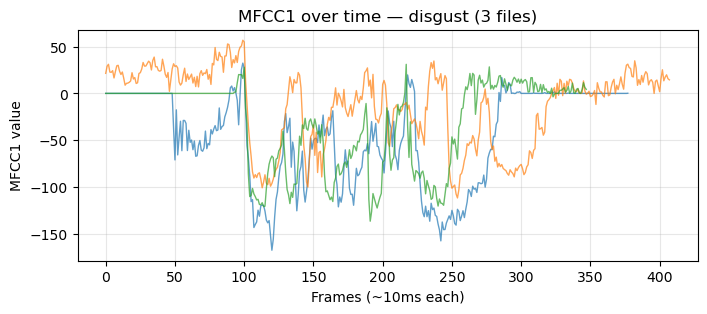

In [98]:
for emo, paths in emo_sample.items():
    plt.figure(figsize=(8,3))
    for p in paths:
        seq = mfcc_coef_sequence(p, COEF)
        plt.plot(seq, alpha=0.7, linewidth=1)

    plt.title(f"MFCC{COEF} over time — {emo} ({len(paths)} files)")
    plt.xlabel("Frames (~10ms each)")
    plt.ylabel(f"MFCC{COEF} value")
    plt.grid(True, alpha=0.3)
    plt.show()

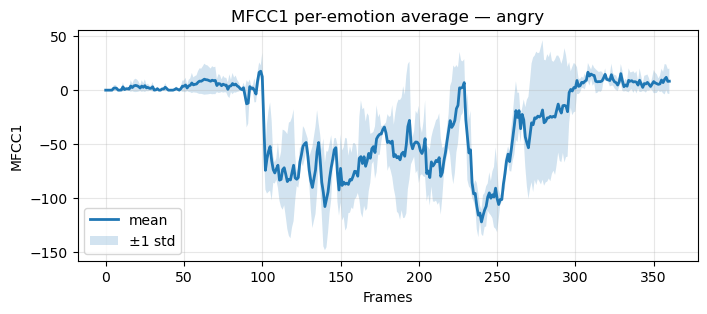

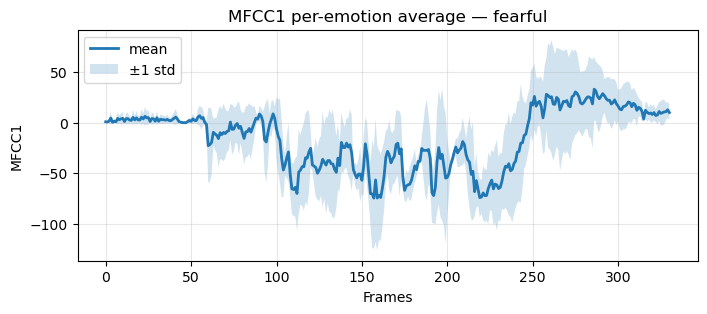

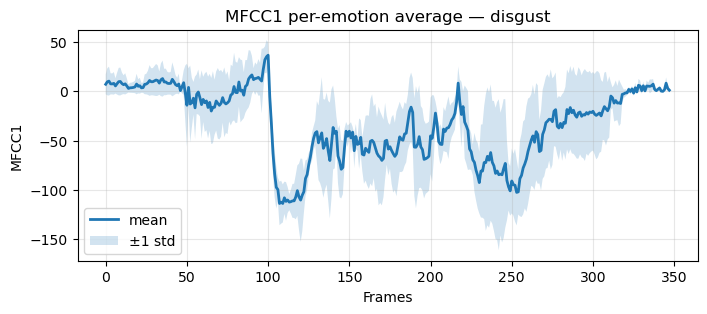

In [99]:
def pad_or_trim_to_min(seqs):
    L = min(len(s) for s in seqs)
    return np.stack([s[:L] for s in seqs], axis=0)  # (N,L)

for emo, paths in emo_sample.items():
    seqs = [mfcc_coef_sequence(p, COEF) for p in paths]
    if len(seqs) == 0:
        continue
    A = pad_or_trim_to_min(seqs)
    mean = A.mean(axis=0); std = A.std(axis=0)

    plt.figure(figsize=(8,3))
    plt.plot(mean, linewidth=2, label="mean")
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.2, label="±1 std")
    plt.title(f"MFCC{COEF} per-emotion average — {emo}")
    plt.xlabel("Frames"); plt.ylabel(f"MFCC{COEF}")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()